In [2]:
import os
import sys
import numpy as np
import pandas as pd
#from scipy.stats import norm

import pybedtools
import re
#import matplotlib as plt
import pyBigWig as pbw
import time
import urllib.request
import matplotlib.pyplot as plt
import json
import requests

{'chr1': 249250621, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr2': 243199373, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566, 'chr3': 198022430, 'chr4': 191154276, 'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 'chr9': 141213431, 'chrX': 155270560}
{'version': 4, 'nLevels': 10, 'nBasesCovered': 3077992836, 'minVal': 0, 'maxVal': 58, 'sumData': 1710485446, 'sumSquared': 6789305911}


In [ ]:
imputed_urls_path="../configs/Imputed_urls.txt"
observed_urls_path="../configs/Observed_urls.txt"

Enhancer_urls=pd.read_csv("../configs/enhancers_urls.txt",
                        header=None, names=['filename'])
Promoter_urls=pd.read_csv("../configs/promoters_urls.txt",
                        header=None, names=['filename'])

imputed_urls=pd.read_csv(imputed_urls_path, header=None, names=['filename'])
observed_urls=pd.read_csv(observed_urls_path, header=None, names=['filename'])

epimap_meta_path="../configs/main_metadata_table.tsv"

epimap_meta=pd.read_csv(epimap_meta_path, sep="\t")

def strip_to_sample(input_url):
    return(input_url.split(sep="_")[0])

Promoter_urls_samples=Promoter_urls.apply(lambda x: strip_to_sample(x['filename']), axis=1)
Enhancer_urls_samples=Enhancer_urls.apply(lambda x: strip_to_sample(x['filename']), axis=1)

epimap_meta=epimap_meta.loc[epimap_meta['id'].isin(Enhancer_urls_samples) & epimap_meta['id'].isin(Promoter_urls_samples)]

In [ ]:
from collections import OrderedDict
cols = OrderedDict([
    ('id', 'Sample_id'),
    ('GROUP', 'GROUP'),
    ('infoline', 'infoline')
])

#epimap_cells=epimap_meta[:, cols.keys()]
#epimap_cells.to_csv("epimap_cell_types.tsv", sep="\t")
print(epimap_meta.loc[epimap_meta['GROUP'].str.contains("Epithelial")])
#print(epimap_meta.loc[epimap_meta['infoline'].str.contains("INTEST")])
#print(epimap_meta.loc[epimap_meta['id'].str.contains("BSS01068")])
#print(epimap_meta['SECONDARY'].unique())
#print(epimap_meta['ct'].unique())
#print(epimap_meta['infoline'].unique())

In [12]:
celltype_mappings = pd.read_json("../configs/tissues_cl_curated.json.gz", 
                        orient='records', lines=True)
print(celltype_mappings)
celltype_mappings.to_csv("../configs/tissue_mappings.tsv", sep="\t")

                                               traitId  \
0             [BSS00121, BSS00122, BSS00123, BSS00124]   
1                                           [BSS00387]   
2    [BSS00045, BSS00046, BSS00047, BSS00048, BSS00...   
3                                 [BSS00328, BSS00329]   
4                                 [BSS00526, BSS00528]   
..                                                 ...   
239                                         [BSS01677]   
240           [BSS00178, BSS00179, BSS00180, BSS00181]   
241  [BSS01150, BSS01151, BSS01482, BSS01483, BSS01...   
242           [BSS01217, BSS01223, BSS01224, BSS01225]   
243                               [BSS01340, BSS01341]   

                       traitName     score           efoId  \
0               BODY OF PANCREAS  0.840765  UBERON_0001150   
1    GLOMERULUS ENDOTHELIAL CELL  0.879627      CL_0002188   
2                  ADRENAL GLAND  1.000000  UBERON_0002369   
3                            EYE  1.000000  UBERON_0000

In [34]:
def Make_mapping_url(Cell_type):
    return("https://www.ebi.ac.uk/ols/api/select?q="+Cell_type.replace(" ", "\%20")+"&ontology=uberon")

URL_test=Make_mapping_url(epimap_meta['infoline'][418])
response=requests.get(URL_test)

parsed=json.loads(response.text)
#print(json.dumps(parsed, indent=4))
print(parsed["response"]["docs"][0])

{'id': 'uberon:class:http://purl.obolibrary.org/obo/UBERON_0002113', 'iri': 'http://purl.obolibrary.org/obo/UBERON_0002113', 'short_form': 'UBERON_0002113', 'obo_id': 'UBERON:0002113', 'label': 'kidney', 'ontology_name': 'uberon', 'ontology_prefix': 'UBERON', 'type': 'class'}


In [4]:
epimap_meta.loc[epimap_meta['id'].str.contains("BSS00215")]

,id,GROUP,ct,SECONDARY,infoline,origin,perturb,lifestage,age,age.units,sex,type,COLOR,category,Project,Donor,name
142,BSS00215,Placenta & EEM,chorionic_villus_female_embryo_(40_weeks),NaN,CHORIONIC VILLUS,NaN,NaN,embryonic,40,week,female,tissue,#E10000,Tissue,Roadmap (New),ENCDO651ROT,chorionic villus female embryo (40 weeks)


NameError: name 'Cell_types_to_run' is not defined

In [14]:
def Get_bigwig_URLs(Celltype, Chromatin_mark):
    Matched_celltype=epimap_meta.loc[epimap_meta['GROUP'].str.contains(Celltype)].reset_index()
    Matched_URLs=[]
    for i in Matched_celltype['id']:
        Imputed_search=imputed_urls.loc[imputed_urls['filename'].str.contains(i+"_"+Chromatin_mark)].reset_index()
        if Imputed_search.empty == False:
            Matched_URLs.append("https://epigenome.wustl.edu/epimap/data/imputed/"
                                +Imputed_search.iloc[0]['filename'])
            continue

        Observed_search=observed_urls.loc[observed_urls['filename'].str.contains(Chromatin_mark+"_"+i)].reset_index()
        if Observed_search.empty == False:
            Matched_URLs.append("https://epigenome.wustl.edu/epimap/data/observed/"
                                +Observed_search.iloc[0]['filename'])
    Out_file=open("/home/xg1/CHEERS/epimap/to_download/"+Celltype+"_"+Chromatin_mark+".txt", "w")
    for i in Matched_URLs:
        Out_file.write(i+"\n")
    Out_file.close
    return(Matched_URLs)

#Digestive_URLs=Get_bigwig_URLs(Celltype='Digestive', Chromatin_mark='H3K27ac')
#Tcell_URLs=Get_bigwig_URLs(Celltype='Blood & T-cell', Chromatin_mark='H3K27ac')
#Get_bigwig_URLs(Celltype='Bone', Chromatin_mark='H3K27ac')


In [15]:
def Get_Sample_IDs(Cell_type):
    Matched_celltype=epimap_meta.loc[epimap_meta['GROUP'].str.contains(Cell_type)].reset_index()
    return(Matched_celltype['id'])
    

def Get_regulatory_URLs(Sample_ID):
    enhancer_page="https://personal.broadinstitute.org/cboix/epimap/mark_matrices/enhancers_bysample/"
    promoter_page="https://personal.broadinstitute.org/cboix/epimap/mark_matrices/promoters_bysample/"
    
    enhancer_file=Enhancer_urls.loc[Enhancer_urls['filename'].str.contains(Sample_ID)].reset_index()
    promoter_file=Promoter_urls.loc[Promoter_urls['filename'].str.contains(Sample_ID)].reset_index()
    
    return([enhancer_page+enhancer_file.iloc[0]['filename'], 
            promoter_page+promoter_file.iloc[0]['filename']])

def Get_BW_URLs(Sample_ID, Chromatin_mark):
    Imputed_search=imputed_urls.loc[imputed_urls['filename'].str.contains(Sample_ID+"_"+Chromatin_mark)].reset_index()
    if Imputed_search.empty == False:
        Matched_URLs="https://epigenome.wustl.edu/epimap/data/imputed/"+Imputed_search.iloc[0]['filename']
    Observed_search=observed_urls.loc[observed_urls['filename'].str.contains(Chromatin_mark+"_"+Sample_ID)].reset_index()
    if Observed_search.empty == False:
        Matched_URLs="https://epigenome.wustl.edu/epimap/data/observed/"+Observed_search.iloc[0]['filename']
    return(Matched_URLs)


In [74]:
start_time1 = time.time()
Digest_bw=pbw.open(Digestive_URLs[0])
end_time1 = time.time()
running_time = (end_time1 - start_time1)

print(running_time)

Get_regulatory_URLs("BSS00001")

1.576561689376831


['https://personal.broadinstitute.org/cboix/epimap/mark_matrices/enhancers_bysample/BSS00001_CA.PRAD.EPITH.22RV1_hg19_enhancer_list.bed.gz',
 'https://personal.broadinstitute.org/cboix/epimap/mark_matrices/promoters_bysample/BSS00001_CA.PRAD.EPITH.22RV1_hg19_promoter_list.bed.gz']

In [84]:
Test_enhancers['BSS00001']=Test_signal
Test_enhancers.head()

,chr,start,end,name,BSS00001
0,chr1,715174,715352,chunk0004_20_3,67.629999
1,chr1,839052,839380,chunk0004_255_1,218.670001
2,chr1,839180,839480,chunk0004_256_1,211.849999
3,chr1,841280,841580,chunk0004_271_1,155.399998
4,chr1,841382,841780,chunk0004_273_1,241.089997


In [ ]:

Cell_types_to_run=epimap_meta['GROUP'].unique()
#del epimap_meta['GROUP'].unique()[(range(0, 6))]
Cell_types_to_run=np.delete(Cell_types_to_run, range(0, 7))
Cell_types_to_run

In [6]:
# Define list of cell types to run
start_time1 = time.time()

#Cell_types_to_run=['Digestive', 'Blood & T-cell', 'Bone', 'Brain', 'Adipose', 'Mesench', 
#                 'Endocrine', 'Stromal', 'Epithelial', 'Heart', 'HSC & B-cell', 'ES-deriv', 'Pancreas',
#                  'Endothelial'];

Cell_types_to_run=epimap_meta['GROUP'].unique()
#Get_Sample_IDs(Cell_types_to_run[0])[0:5]

# Get their associated Promoter+Enhancer files:

for cell in Cell_types_to_run:
    cell_IDs=Get_Sample_IDs(cell)
    for sample_ID in cell_IDs:
        Reg_URLs=Get_regulatory_URLs(sample_ID)
        urllib.request.urlretrieve(Reg_URLs[0], "../saved/"+sample_ID+"_enhancer.bed.gz")
        urllib.request.urlretrieve(Reg_URLs[1], "../saved/"+sample_ID+"_promoter.bed.gz")
        
        #Current_enhancers=pybedtools.BedTool("../saved/"+sample_ID+"_enhancer.bed.gz")
        #Current_enhancers_pd=pd.read_table(Current_enhancers.fn)
        #Current_enhancers_pd.to_csv("/home/xg1/CHEERS/epimap/regulatory_elements/Master_enhancers.bed",
        #                            mode='a', header=False, sep="\t", index=False)
        
        #Current_promoters=pybedtools.BedTool("/home/xg1/"+sample_ID+"_promoter.bed.gz")
        #Current_promoters_pd=pd.read_table(Current_promoters.fn)
        #Current_promoters_pd.to_csv("/home/xg1/CHEERS/epimap/regulatory_elements/Master_enhancers.bed",
         #                           mode='a', header=False, sep="\t", index=False)
        
# Merge the Promoter+enhancer files

#Master_enhancers=pybedtools.BedTool("/home/xg1/CHEERS/epimap/regulatory_elements/Master_enhancers.bed")
#Master_enhancers_sorted=Master_enhancers.sort()
#Master_enhancers_merged=Master_enhancers_sorted.merge(d=50)
#Master_enhancers_merged.to_csv("/home/xg1/CHEERS/epimap/regulatory_elements/Master_enhancers.bed",
 #                            header=False, sep="\t", index=False)
#Master_enhancers_merged.saveas("/home/xg1/CHEERS/epimap/regulatory_elements/#Master_enhancers.sorted.merged.bed")

end_time1 = time.time()
running_time = (end_time1 - start_time1)
print(running_time)



1897.032071352005


In [ ]:
for cell in Cell_types_to_run:
    print(cell+": "+str(len(Get_Sample_IDs(cell))))

In [ ]:
Cell_counts=[]
for cell in Cell_types_to_run:
    Cell_counts.append(len(Get_Sample_IDs(cell)))

print(Cell_counts)

In [ ]:
plt.bar(Cell_types_to_run, Cell_counts)
plt.xticks(rotation=90)

In [ ]:
Master_enhancers=pybedtools.BedTool("../output/Master_enhancers.bed")
Master_enhancers_sorted=Master_enhancers.sort()
Master_enhancers_merged=Master_enhancers_sorted.merge(d=50)

In [ ]:

Master_merged_pd=pd.read_table("/home/xg1/CHEERS/epimap/regulatory_elements/Master_enhancers.sorted.merged.bed")
# Loop through bigwig URLs and get signal counts in merged peaks

for cell in Cell_types_to_run:
    cell_IDs=Get_Sample_IDs(cell)[0:5]
    for sample_ID in cell_IDs:
        BW_URL=Get_BW_URLs(sample_ID, "DNase-seq")
        Current_BW=pbw.open(BW_URL)
        Signals=Master_merged_pd.apply(lambda x: print(sum(Current_BW.values(x['chr'], x['start'],
                                                               x['end']))), axis=1)
        Master_merged_pd=pd.concat([Master_merged_pd, Signals], axis=1)


    

Digestive_URLs=Get_bigwig_URLs(Celltype='Digestive', Chromatin_mark='H3K27ac')
Tcell_URLs=Get_bigwig_URLs(Celltype='Blood & T-cell', Chromatin_mark='H3K27ac')
# Write to file for CHEERS_normalize

In [21]:
Master_merged_pd=pd.read_table("../output/Master_enhancers.sorted.merged.bed", 
                              header=None, names=['chr', 'start', 'end'])
# Loop through bigwig URLs and get signal counts in merged peaks
#Cell_types_to_run=epimap_meta['GROUP'].unique()
for cell in Cell_types_to_run:
    cell_IDs=Get_Sample_IDs(cell)
    for sample_ID in cell_IDs:
        BW_URL=Get_BW_URLs(sample_ID, "DNase-seq")
        Current_BW=pbw.open(BW_URL)
        Signals=Master_merged_pd.apply(lambda x: sum(Current_BW.values(x['chr'], x['start'],
                                                               x['end'])), axis=1)
        Master_merged_pd['signal']=Signals

        Master_merged_pd.to_csv("../output/DNase_ReadsInPeaks/"+sample_ID+"_ReadsInPeaks.txt",
                                sep="\t", index=False, header=['chrom', 'start', 'end', sample_ID])

    

In [ ]:
Master_merged_pd

In [ ]:
start_time1 = time.time()
Master_merged_pd=pd.read_table("../tmp/temp_enhancer.bed.gz", 
                              header=0)
BW_URL=Get_BW_URLs("BSS00001", "DNase-seq")
Current_BW=pbw.open(BW_URL)
Signals=Master_merged_pd.apply(lambda x: sum(Current_BW.values(x['chr'], x['start'],
                                                               x['end'])), axis=1)
Master_merged_pd["BSS00001"]=Signals

end_time1 = time.time()
running_time = (end_time1 - start_time1)
print(running_time)


In [ ]:
Study_table=pd.read_json("/home/xg1/genetics-v2d-data/tmp/210601/merged_study_table.json",orient='records', lines=True)

Study_table.head()

Bowels_study_table=Study_table.loc[Study_table['trait_reported'].str.contains(
        'IBD|Bowel', flags=re.I, regex=True)]
print(Bowels_study_table)

In [ ]:
IBD_SNPs=pd.read_csv("/home/xg1/CHEERS/GCST004131_finemapping.tsv", 
                     sep="\t", 
                     names=["study_id", "lead_chrom", "lead_pos", "lead_ref", "lead_alt", "tag_chrom",
                            "tag_pos", "tag_ref", "tag_alt", "log10_ABF", "posterior_prob"])
print(IBD_SNPs)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(IBD_SNPs['posterior_prob'], range=(0, 0.1), bins=100)

unique_sets=IBD_SNPs.lead_pos.unique()

In [ ]:
print(len(unique_sets))
#print(IBD_SNPs.loc[IBD_SNPs['lead_pos'] == unique_sets[0]])
#for i in unique_sets:
#    print(i)
df_test=IBD_SNPs.loc[IBD_SNPs['lead_pos'] == unique_sets[0]]
print(df_test.shape[0])
print(df_test['posterior_prob'][0])

In [105]:
Credset_size=[]
Top_set_PP=[]

for i in unique_sets:
    Current_credset=IBD_SNPs.loc[IBD_SNPs['lead_pos'] == i].reset_index()
    Credset_size.append(Current_credset.shape[0])
    Top_set_PP.append(Current_credset['posterior_prob'][0])
    
    


In [ ]:
plt.scatter(Credset_size, Top_set_PP)

plt.xlim(0, 210)
plt.ylabel("Top Credset Posterior")
plt.xlabel("Credset size (n SNPs)")

In [ ]:
Filtered_Credset=IBD_SNPs.loc[IBD_SNPs['posterior_prob'] > 0.01].reset_index()
print(Filtered_Credset)
len(Filtered_Credset.lead_pos.unique())


In [ ]:
Credset_size=[]
Top_set_PP=[]

for i in unique_sets:
    Current_credset=Filtered_Credset.loc[Filtered_Credset['lead_pos'] == i].reset_index()
    Credset_size.append(Current_credset.shape[0])
    Top_set_PP.append(Current_credset['posterior_prob'][0])
    
plt.scatter(Credset_size, Top_set_PP)
plt.xlim(0, 210)
plt.ylabel("Top Credset Posterior")
plt.xlabel("Credset size (n SNPs)")

In [ ]:
from collections import OrderedDict
cols = OrderedDict([
    ('tag_chrom', 'chrom'),
    ('tag_pos', 'pos'),
    ('lead_pos', 'end'),
    ('posterior_prob', 'PP')
    ])

Filtered_Credset_bed=Filtered_Credset.loc[:,list(cols.keys())].rename(columns=cols)
Filtered_Credset_bed['end']=Filtered_Credset_bed['pos']+1
#Filtered_Credset_bed['chrom']='chr'+Filtered_Credset_bed['chrom'].str()
print(Filtered_Credset_bed)

Filtered_Credset_bed.to_csv("/home/xg1/CHEERS/input_SNPs/Filtered_GCST004131_hg38.bed", 
                            sep="\t", header=False, index=False)



In [109]:
IBD_SNPs_bed=IBD_SNPs.loc[:,list(cols.keys())].rename(columns=cols)
IBD_SNPs_bed['end']=IBD_SNPs_bed['pos']+1
#Filtered_Credset_bed['chrom']='chr'+Filtered_Credset_bed['chrom'].str()
print(IBD_SNPs_bed)

IBD_SNPs_bed.to_csv("/home/xg1/CHEERS/input_SNPs/GCST004131_hg38.bed", 
                            sep="\t", header=False, index=False)


      chrom        pos        end        PP
0         1    8108201    8108202  0.079383
1         1    8092042    8092043  0.063345
2         1    8120150    8120151  0.057142
3         1    8109690    8109691  0.055842
4         1    8108933    8108934  0.052517
...     ...        ...        ...       ...
3268      9  136382607  136382608  0.037406
3269      9  136377295  136377296  0.037316
3270      9  136378050  136378051  0.034006
3271      9  136377398  136377399  0.033819
3272      9  136387395  136387396  0.030455

[3273 rows x 4 columns]


In [131]:
#Plotting CHEERS outputs
Raw_IBD_P=pd.read_csv("/home/xg1/CHEERS/Results/Raw_IBD_disease_enrichment_pValues.txt",
                      sep="\t", header=None, names=["Sample", "P"])
Filtered_IBD_P=pd.read_csv("/home/xg1/CHEERS/Results/Filtered_IBD_disease_enrichment_pValues.txt",
                      sep="\t", header=None, names=["Sample", "P"])
print(Raw_IBD_P)

     Sample         P
0  BSS01666  0.138431
1  BSS01667  0.027658
2  BSS01688  0.572942
3  BSS01665  0.082752
4  BSS00092  0.734281
5  BSS00091  0.876472
6  BSS00090  0.834271
7  BSS01684  0.273462
8  BSS01687  0.123318


In [149]:
Sample_group=[]
for i in Raw_IBD_P['Sample']:
    tmp=epimap_meta.loc[epimap_meta['id'].str.contains(i)]
    print(tmp.iloc[0]['GROUP'])
    Sample_group.append(tmp.iloc[0]['GROUP'])
    
Raw_IBD_P['GROUP']=Sample_group
print(Raw_IBD_P)

Adipose
Adipose
Blood & T-cell
Adipose
Brain
Brain
Brain
Blood & T-cell
Blood & T-cell
     Sample         P           GROUP
0  BSS01666  0.138431         Adipose
1  BSS01667  0.027658         Adipose
2  BSS01688  0.572942  Blood & T-cell
3  BSS01665  0.082752         Adipose
4  BSS00092  0.734281           Brain
5  BSS00091  0.876472           Brain
6  BSS00090  0.834271           Brain
7  BSS01684  0.273462  Blood & T-cell
8  BSS01687  0.123318  Blood & T-cell


In [94]:
def add_GROUP(CHEERS_res):
    Sample_group=[]
    Sample_info=[]
    for i in CHEERS_res['Sample']:
        tmp=epimap_meta.loc[epimap_meta['id'].str.contains(i)]
        #print(tmp.iloc[0]['GROUP'])
        Sample_group.append(tmp.iloc[0]['GROUP'])
        Sample_info.append(tmp.iloc[0]['infoline'])
    CHEERS_res['GROUP']=Sample_group
    CHEERS_res['infoline']=Sample_info
    return(CHEERS_res)

#Raw_IBD_P=add_GROUP(Raw_IBD_P)
#Filtered_IBD_P=add_GROUP(Filtered_IBD_P)
#print(Filtered_IBD_P)

In [95]:
Corrected_IBD_P=pd.read_csv("/home/xg1/CHEERS/Results/IBD_Correct_DNase_disease_enrichment_pValues.txt",
                      sep="\t", header=None, names=["Sample", "P"])
Corrected_IBD_P=add_GROUP(Corrected_IBD_P)
print(Corrected_IBD_P)

      Sample         P           GROUP              infoline
0   BSS00228  0.520627       Digestive          COLON MUCOSA
1   BSS01397  0.995545            Bone            OSTEOBLAST
2   BSS00316  0.334695       Digestive             ESOPHAGUS
3   BSS00189  0.013070  Blood & T-cell            CD4 T CELL
4   BSS00188  0.068106  Blood & T-cell            CD4 T CELL
5   BSS00705  0.961728            Bone    BONE MARROW STROMA
6   BSS00270  0.429286       Digestive       DUODENUM MUCOSA
7   BSS00185  0.000740  Blood & T-cell            CD4 T CELL
8   BSS00271  0.119898       Digestive       DUODENUM MUCOSA
9   BSS00186  0.001875  Blood & T-cell            CD4 T CELL
10  BSS00183  0.001151  Blood & T-cell            CD4 T CELL
11  BSS00227  0.693871       Digestive          COLON MUCOSA
12  BSS00084  0.740271            Bone              BONE ARM
13  BSS00078  0.168208           Brain         ANGULAR GYRUS
14  BSS00090  0.944850           Brain  ASTROCYTE CEREBELLUM
15  BSS00071  0.914545  

In [96]:
Corrected_IBD_P=pd.read_csv("/home/xg1/CHEERS/Results/IBD_GCST_DNase_disease_enrichment_pValues.txt",
                      sep="\t", header=None, names=["Sample", "P"])
Corrected_IBD_P=add_GROUP(Corrected_IBD_P)
print(Corrected_IBD_P)

      Sample         P           GROUP              infoline
0   BSS00228  0.001784       Digestive          COLON MUCOSA
1   BSS01397  0.998806            Bone            OSTEOBLAST
2   BSS00316  0.001403       Digestive             ESOPHAGUS
3   BSS00189  0.002817  Blood & T-cell            CD4 T CELL
4   BSS00188  0.127540  Blood & T-cell            CD4 T CELL
5   BSS00705  0.907412            Bone    BONE MARROW STROMA
6   BSS00270  0.005496       Digestive       DUODENUM MUCOSA
7   BSS00185  0.000047  Blood & T-cell            CD4 T CELL
8   BSS00271  0.000715       Digestive       DUODENUM MUCOSA
9   BSS00186  0.003825  Blood & T-cell            CD4 T CELL
10  BSS00183  0.002605  Blood & T-cell            CD4 T CELL
11  BSS00227  0.060636       Digestive          COLON MUCOSA
12  BSS00084  0.609663            Bone              BONE ARM
13  BSS00078  0.028365           Brain         ANGULAR GYRUS
14  BSS00090  0.913756           Brain  ASTROCYTE CEREBELLUM
15  BSS00071  0.212923  

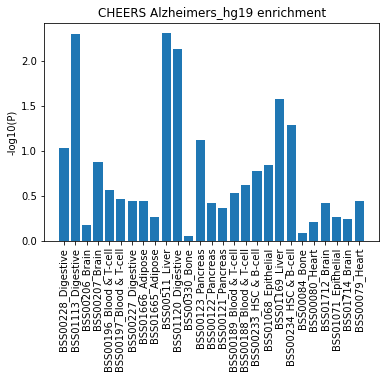

In [9]:
import pandas as pd
#from scipy.stats import norm

import pybedtools
import re
#import matplotlib as plt
import pyBigWig as pbw
import time
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

epimap_meta_path="../configs/main_metadata_table.tsv"
epimap_meta=pd.read_csv(epimap_meta_path, sep="\t")

def add_GROUP(CHEERS_res):
    Sample_group=[]
    Sample_info=[]
    for i in CHEERS_res['Sample']:
        tmp=epimap_meta.loc[epimap_meta['id'].str.contains(i)]
        #print(tmp.iloc[0]['GROUP'])
        Sample_group.append(tmp.iloc[0]['GROUP'])
        Sample_info.append(tmp.iloc[0]['infoline'])
    CHEERS_res['GROUP']=Sample_group
    CHEERS_res['infoline']=Sample_info
    return(CHEERS_res)

def Plot_CHEERS_result(input_path, out_prefix, out_dir="../notebooks/"):
    CHEERS_result=pd.read_csv(input_path,
                       sep="\t", header=None, names=["Sample", "P"])
    CHEERS_result=add_GROUP(CHEERS_result)

    CHEERS_result['name']=CHEERS_result.apply(lambda x: x['Sample']+"_"+str(x['GROUP']), axis=1)
    
    plt.xticks(rotation=90)
    plt.title("CHEERS "+out_prefix+" enrichment")
    plt.ylabel("-log10(P)")
    plt.bar(CHEERS_result['name'], -np.log10(CHEERS_result['P']), )
    plt.savefig(out_dir+"CHEERS_"+out_prefix+".png")

Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/Alzheimers_disease_enrichment_pValues.txt", out_prefix="Alzheimers_hg19")

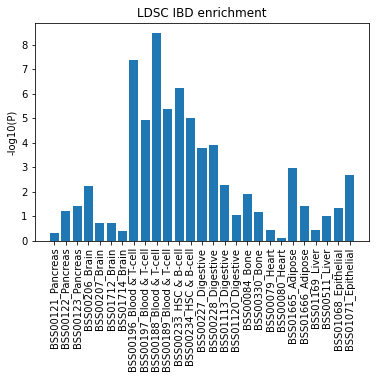

In [12]:
LDSC_results=pd.read_csv("/Users/xg1/Downloads/ldsc/Comparison_IBD_Epimap.results", sep="\t", header=0)
LDSC_results['Sample']=LDSC_results.apply(lambda x: x['Category'].split("L2")[0], axis=1)
LDSC_results=add_GROUP(LDSC_results)

LDSC_results['name']=LDSC_results.apply(lambda x: x['Sample']+"_"+str(x['GROUP']), axis=1)

plt.xticks(rotation=90)
plt.title("LDSC "+"IBD"+" enrichment")
plt.ylabel("-log10(P)")
plt.bar(LDSC_results['name'], -np.log10(LDSC_results['Enrichment_p']), )
plt.savefig("../notebooks/LDSC_"+"IBD"+".png")
#print(LDSC_results)

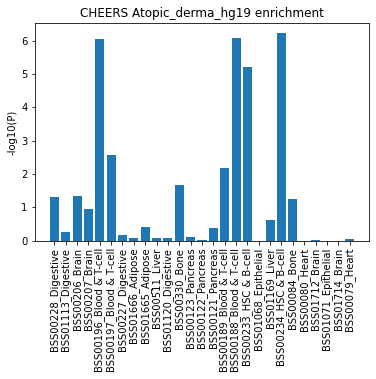

In [32]:
Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/Atopic_disease_enrichment_pValues.txt", out_prefix="Atopic_derma_hg19")

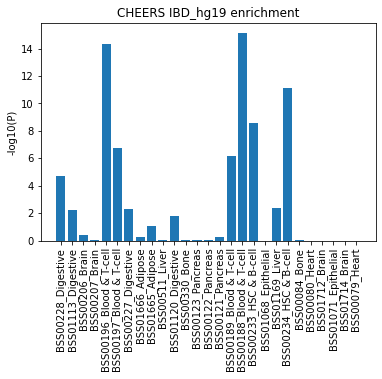

In [33]:
Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/IBD_disease_enrichment_pValues.txt", out_prefix="IBD_hg19")

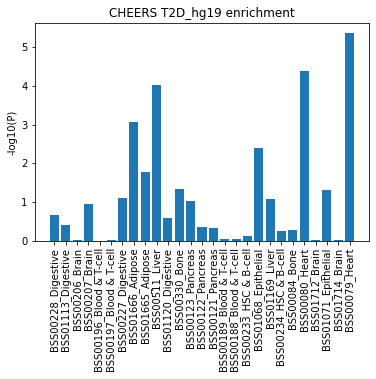

In [34]:
Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/T2D_disease_enrichment_pValues.txt", out_prefix="T2D_hg19")


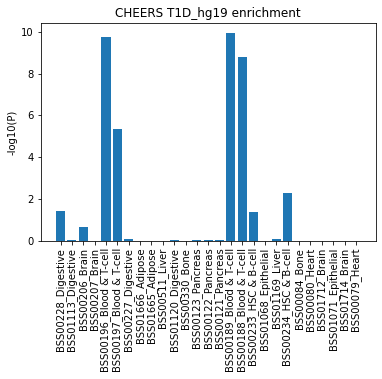

In [ ]:
Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/T1D_disease_enrichment_pValues.txt", out_prefix="T1D_hg19")

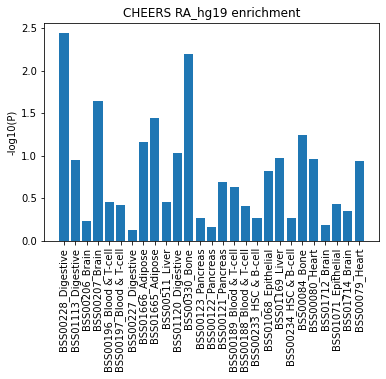

In [ ]:
Plot_CHEERS_result("/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/RA_disease_enrichment_pValues.txt", out_prefix="RA_hg19")